# Assignment 1

Name: Himanshu Singh

Roll: 2023121013

## Imports

In [1]:
from typing import List, Literal, Tuple
import os

import cv2
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from numpy.typing import NDArray

## Constants

In [2]:
PROJECT_DIR = os.getcwd()
IMAGES_DIR = os.path.join(PROJECT_DIR, "src_img")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "out_img")

## Helper Functions

In [3]:
def read_image(src_path: str, color_space: Literal['rgb', 'gray'] = 'rgb') -> NDArray[np.uint8]:
    """ Reads an image into an array, given the absolute path. """

    if color_space == 'rgb':
        image = cv2.imread(src_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_space == 'gray':
        image = cv2.imread(src_path, 0)
    else:
        raise ValueError(f'Unrecognised color space argument {color_space}')
    return image

In [4]:
def write_image(dest_path: str, image: NDArray[np.uint8]) -> None:
    """ Writes an array as an image file, given the absolute path. """

    if image.ndim == 3:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dest_path, image_bgr)
    else:
        cv2.imwrite(dest_path, image)

In [5]:
def display_image(image: NDArray[np.uint8], title: str = '', ax: Axes = None) -> None:
    """ Displays the image represented by an array. """

    if ax is None:
        if image.ndim == 3:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    else:
        if image.ndim == 3:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

In [6]:
def resize_image(image: NDArray[np.uint8], new_height: int, new_width: int) -> NDArray[np.uint8]:
    """ Resizes the given image to new width and height. """

    old_height, old_width, channels = image.shape
    output = np.zeros((new_height, new_width, channels), dtype=np.uint8)

    row_ratio = old_height / new_height
    col_ratio = old_width / new_width

    for idx in range(new_height):
        for jdx in range(new_width):
            xdx = int(idx * row_ratio)
            ydx = int(jdx * col_ratio)
            output[idx, jdx] = image[xdx, ydx]

    return output

## Questions

### 1. Quantization

In [7]:
def quantize_image(image: NDArray[np.uint8], num_bits: int) -> NDArray[np.uint8]:
    """ Creates a quantized version of the image. """

    if not 1 <= num_bits <= 8:
        raise ValueError(f'Out of range argument for num_bits: {num_bits}')

    remove = 8 - num_bits
    mask = np.uint8(255) << remove
    output = image & mask
    return output

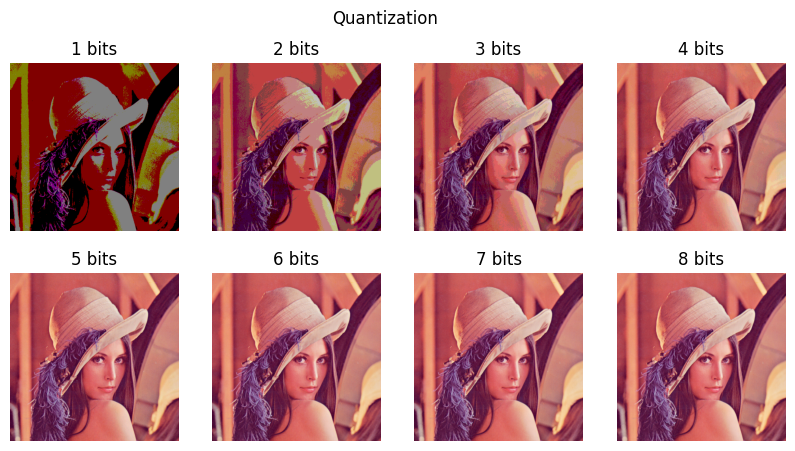

In [8]:
lenna = read_image(f'{IMAGES_DIR}/Lenna.png')
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle('Quantization')

for i, ax in enumerate(axs.flat):
    num_bits = i + 1
    lenna_quant = quantize_image(lenna, num_bits)
    write_image(f'{OUTPUT_DIR}/lenna_{num_bits}.png', lenna_quant)
    display_image(lenna_quant, f'{num_bits} bits', ax)

### 2. Histogram Equalization

#### 2.1 Histogram Equalization Function

In [9]:
def find_histogram(data: NDArray[np.uint8]) -> NDArray[np.int64]:
    """ Given an array of uint8 values, finds the histogram. """

    return np.bincount(data.flatten(), minlength=256)
    # return np.histogram(data, bins=range(257))[0]

def find_channel_histograms(image: NDArray[np.uint8]) -> List[NDArray[np.int64]]:
    """ Given an RGB image, finds the histogram of individual channels. """

    hists = []
    for channel in range(image.shape[2]):
        hists.append(find_histogram(image[:, :, channel]))
    return hists

def histequalize(data: NDArray[np.uint8]) -> Tuple[NDArray[np.uint8], NDArray[np.int64], NDArray[np.int64]]:
    """ Given an 2D/3D array of uint8 values, performs histogram normalization
    and returns the updated array, the original and resulting histogram. """

    pixels = data.shape[0] * data.shape[1]
    if data.ndim == 3:
        pixels *= data.shape[2]

    hist = find_histogram(data)
    cdf = np.cumsum(hist) / pixels
    output = np.rint(cdf[data] * 255)
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output, hist, find_histogram(output)

#### 2.2 Effect of Histogram Equalization

In [10]:
def plot_histogram(hist: NDArray[np.uint8], title: str = '', ax: Axes = None, color: str = 'gray') -> None:
    """ Plots a histogram, given the consecutive frequency counts (from 0). """

    ax.bar(range(hist.shape[0]), hist, color=color)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,3))
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')
    ax.set_title(title)

In [11]:
painting = read_image(f'{IMAGES_DIR}/painting.jpg')
painting_equalized, painting_hist, painting_equalized_hist = histequalize(painting)
write_image(f'{OUTPUT_DIR}/painting_equalized.png', painting_equalized)

image = read_image(f'{IMAGES_DIR}/image.jpg')
image_equalized, image_hist, image_equalized_hist = histequalize(image)
write_image(f'{OUTPUT_DIR}/image_equalized.png', image_equalized)

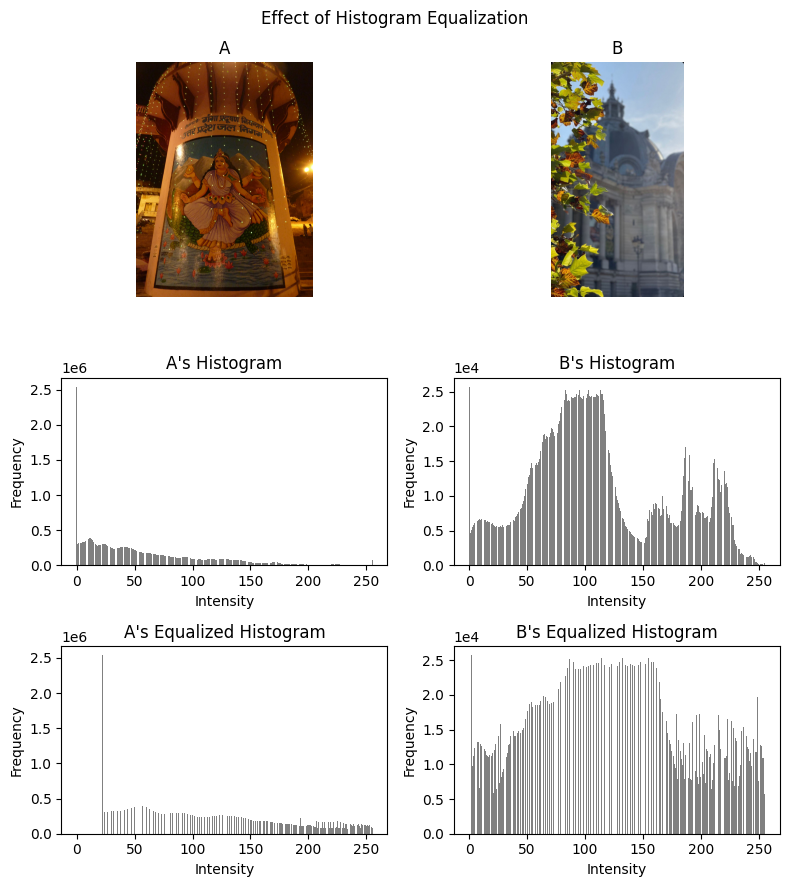

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(8, 9), height_ratios=[1.25, 1, 1])
fig.suptitle('Effect of Histogram Equalization')

display_image(painting, 'A', axs[0][0])
plot_histogram(painting_hist, 'A\'s Histogram', axs[1][0])
plot_histogram(painting_equalized_hist, 'A\'s Equalized Histogram', axs[2][0])

display_image(image, 'B', axs[0][1])
plot_histogram(image_hist, 'B\'s Histogram', axs[1][1])
plot_histogram(image_equalized_hist, 'B\'s Equalized Histogram', axs[2][1])

plt.tight_layout()

##### Qn: Is this a good representation for a colored image's histogram?

Ans: No. The key difference between a grayscale and colored image is that all intensities are not the same. A high intensity red is not the same as a high intensity green (for example). Representing them all in a common histogram and equalizing them all alike, may end up inverting the nature of the channel's original distribution. To illustrate this, consider the change in red channel of Image A after equalization.

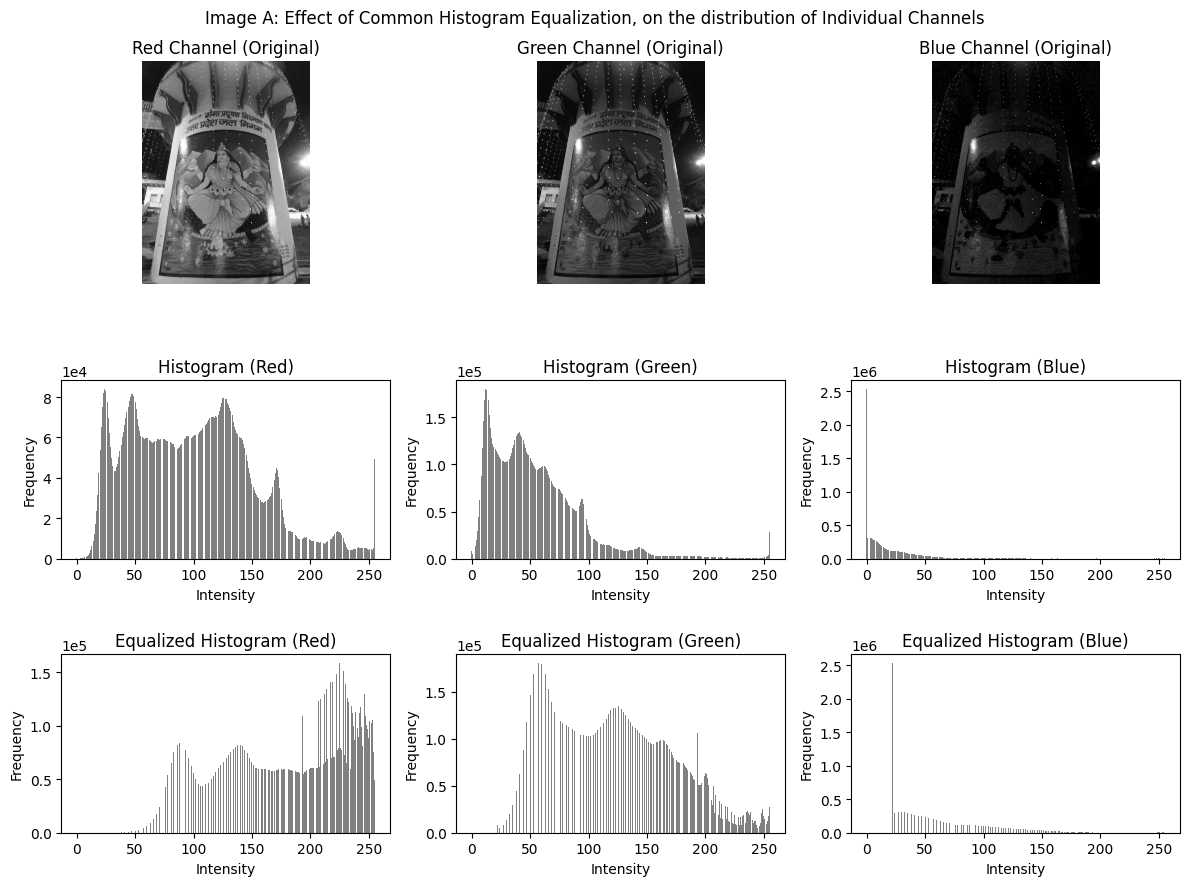

In [13]:
painting_hist_red, painting_hist_green, painting_hist_blue = find_channel_histograms(painting)
painting_equalized_hist_red, painting_equalized_hist_green, painting_equalized_hist_blue = find_channel_histograms(painting_equalized)

fig, axs = plt.subplots(3, 3, figsize=(12, 9), height_ratios=[1.25, 1, 1])
fig.suptitle('Image A: Effect of Common Histogram Equalization, on the distribution of Individual Channels')

display_image(painting[:, :, 0], 'Red Channel (Original)', axs[0][0])
display_image(painting[:, :, 1], 'Green Channel (Original)', axs[0][1])
display_image(painting[:, :, 2], 'Blue Channel (Original)', axs[0][2])

plot_histogram(painting_hist_red, 'Histogram (Red)', axs[1][0])
plot_histogram(painting_hist_green, 'Histogram (Green)', axs[1][1])
plot_histogram(painting_hist_blue, 'Histogram (Blue)', axs[1][2])

plot_histogram(painting_equalized_hist_red, 'Equalized Histogram (Red)', axs[2][0])
plot_histogram(painting_equalized_hist_green, 'Equalized Histogram (Green)', axs[2][1])
plot_histogram(painting_equalized_hist_blue, 'Equalized Histogram (Blue)', axs[2][2])

plt.tight_layout()

#### 2.3 Effect of Histogram Equalization on Individual Channels

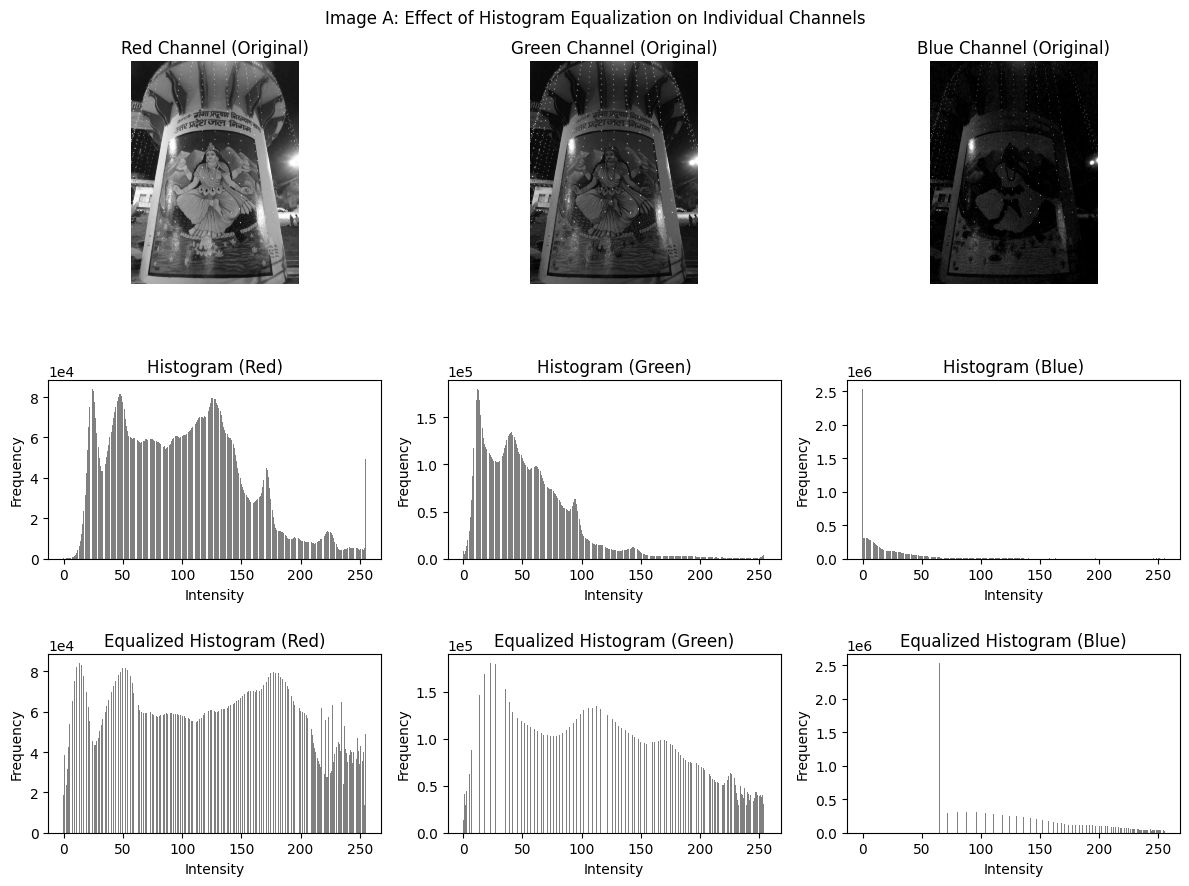

In [14]:
painting_red_equalized, painting_hist_red, painting_red_equalized_hist = histequalize(painting[:, :, 0])
painting_green_equalized, painting_hist_green, painting_green_equalized_hist = histequalize(painting[:, :, 1])
painting_blue_equalized, painting_hist_blue, painting_blue_equalized_hist = histequalize(painting[:, :, 2])

fig, axs = plt.subplots(3, 3, figsize=(12, 9), height_ratios=[1.25, 1, 1])
fig.suptitle('Image A: Effect of Histogram Equalization on Individual Channels')

display_image(painting[:, :, 0], 'Red Channel (Original)', axs[0][0])
display_image(painting[:, :, 1], 'Green Channel (Original)', axs[0][1])
display_image(painting[:, :, 2], 'Blue Channel (Original)', axs[0][2])

plot_histogram(painting_hist_red, 'Histogram (Red)', axs[1][0])
plot_histogram(painting_hist_green, 'Histogram (Green)', axs[1][1])
plot_histogram(painting_hist_blue, 'Histogram (Blue)', axs[1][2])

plot_histogram(painting_red_equalized_hist, 'Equalized Histogram (Red)', axs[2][0])
plot_histogram(painting_green_equalized_hist, 'Equalized Histogram (Green)', axs[2][1])
plot_histogram(painting_blue_equalized_hist, 'Equalized Histogram (Blue)', axs[2][2])

plt.tight_layout()

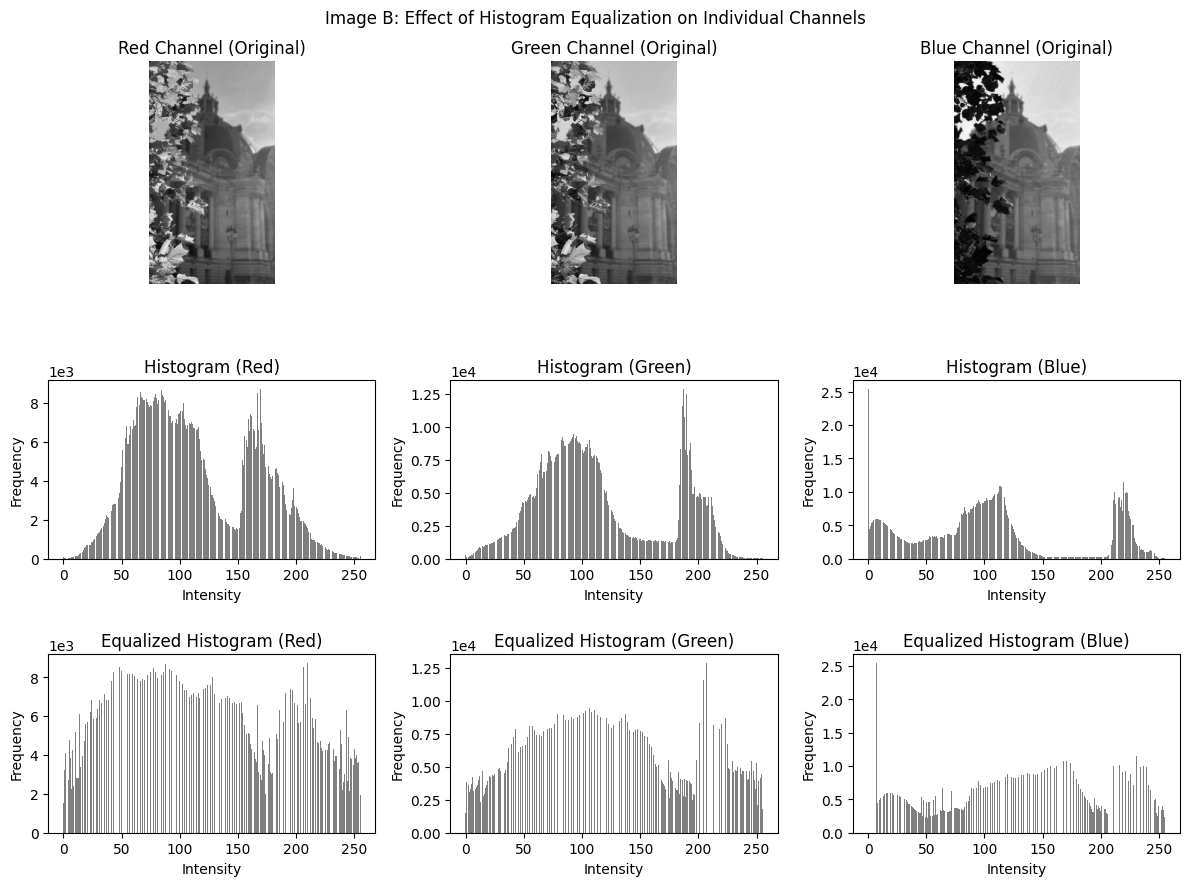

In [15]:
image_red_equalized, image_hist_red, image_red_equalized_hist = histequalize(image[:, :, 0])
image_green_equalized, image_hist_green, image_green_equalized_hist = histequalize(image[:, :, 1])
image_blue_equalized, image_hist_blue, image_blue_equalized_hist = histequalize(image[:, :, 2])

fig, axs = plt.subplots(3, 3, figsize=(12, 9), height_ratios=[1.25, 1, 1])
fig.suptitle('Image B: Effect of Histogram Equalization on Individual Channels')

display_image(image[:, :, 0], 'Red Channel (Original)', axs[0][0])
display_image(image[:, :, 1], 'Green Channel (Original)', axs[0][1])
display_image(image[:, :, 2], 'Blue Channel (Original)', axs[0][2])

plot_histogram(image_hist_red, 'Histogram (Red)', axs[1][0])
plot_histogram(image_hist_green, 'Histogram (Green)', axs[1][1])
plot_histogram(image_hist_blue, 'Histogram (Blue)', axs[1][2])

plot_histogram(image_red_equalized_hist, 'Equalized Histogram (Red)', axs[2][0])
plot_histogram(image_green_equalized_hist, 'Equalized Histogram (Green)', axs[2][1])
plot_histogram(image_blue_equalized_hist, 'Equalized Histogram (Blue)', axs[2][2])

plt.tight_layout()

#### 2.4 RGB Channels after Histogram Equalization

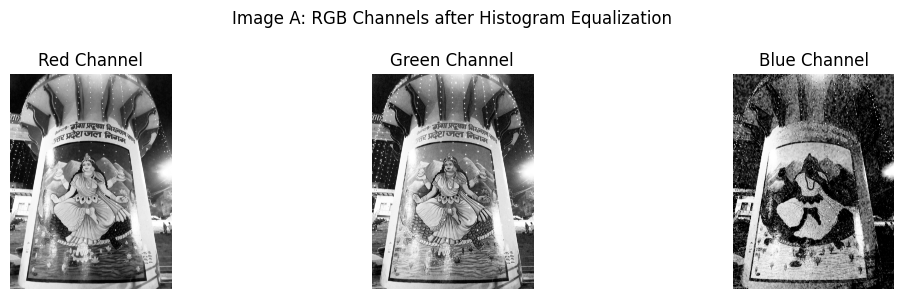

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Image A: RGB Channels after Histogram Equalization')

display_image(painting_red_equalized, 'Red Channel', axs[0])
display_image(painting_green_equalized, 'Green Channel', axs[1])
display_image(painting_blue_equalized, 'Blue Channel', axs[2])

plt.tight_layout()

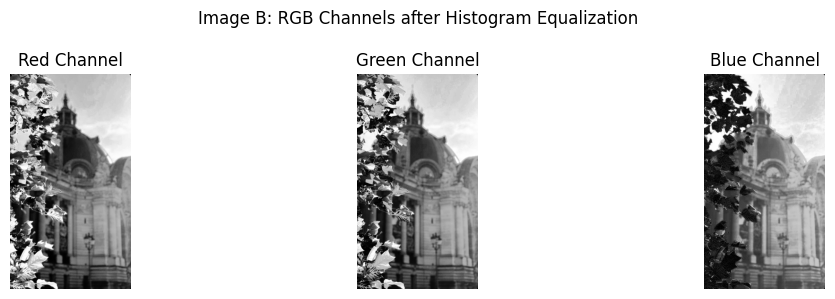

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Image B: RGB Channels after Histogram Equalization')

display_image(image_red_equalized, 'Red Channel', axs[0])
display_image(image_green_equalized, 'Green Channel', axs[1])
display_image(image_blue_equalized, 'Blue Channel', axs[2])

plt.tight_layout()

#### 2.5 Overall Effect of Histogram Equalization on Individual Channels

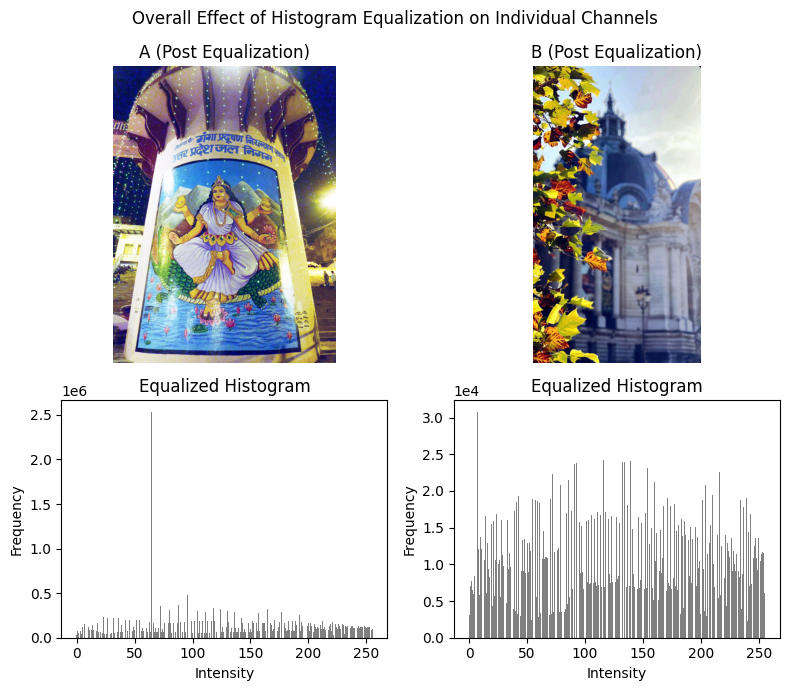

In [18]:
painting_channel_equalized = np.stack((painting_red_equalized, painting_green_equalized, \
                                painting_blue_equalized), axis=-1)
painting_channel_equalized_hist = find_histogram(painting_channel_equalized)
write_image(f'{OUTPUT_DIR}/painting_channel_equalized.png', painting_channel_equalized)

image_channel_equalized = np.stack((image_red_equalized, image_green_equalized, \
                                image_blue_equalized), axis=-1)
image_channel_equalized_hist = find_histogram(image_channel_equalized)
write_image(f'{OUTPUT_DIR}/image_channel_equalized.png', image_channel_equalized)

fig, axs = plt.subplots(2, 2, figsize=(8, 7), height_ratios=[1.25, 1])
fig.suptitle('Overall Effect of Histogram Equalization on Individual Channels')

display_image(painting_channel_equalized, 'A (Post Equalization)', axs[0][0])
display_image(image_channel_equalized, 'B (Post Equalization)', axs[0][1])

plot_histogram(painting_channel_equalized_hist, 'Equalized Histogram', axs[1][0])
plot_histogram(image_channel_equalized_hist,  'Equalized Histogram', axs[1][1])

plt.tight_layout()

#### 2.6 Difference between Concatenated and Final Histograms

In [19]:
def plot_concatenated_histogram(
    hists: List[NDArray[np.uint8]], label: List[str], color: List[str],
    title: str = '', ax: Axes = None
) -> None:
    """ Plots a concatentaed histogram, given a list of consecutive frequency counts (from 0). """

    for idx, hist in enumerate(hists):
        ax.bar(range(hist.shape[0]), hist, label=label[idx], color=color[idx])
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,3))
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()

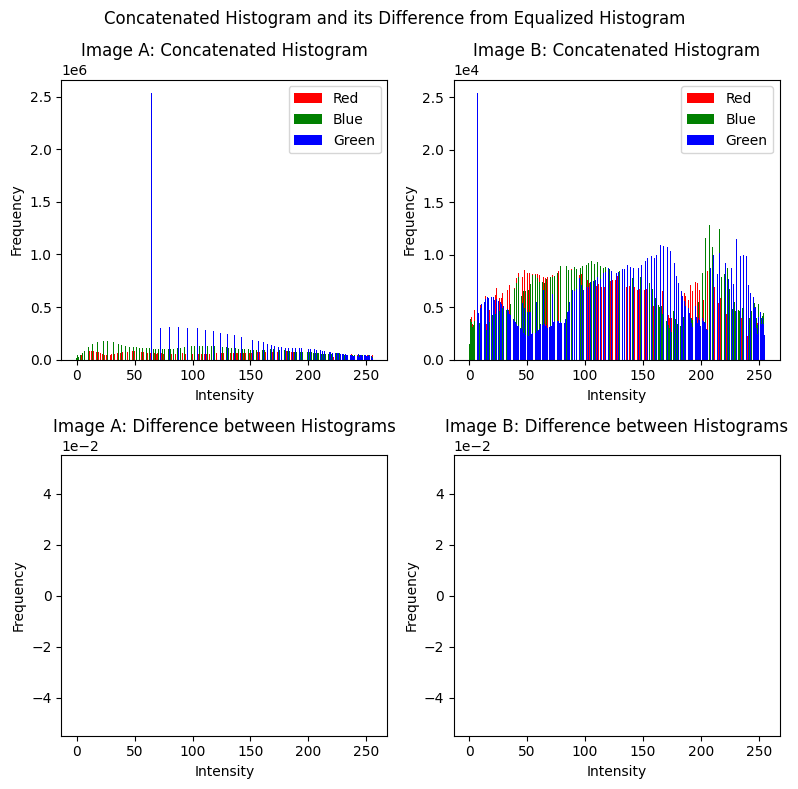

In [20]:
painting_channel_equalized_hist_diff = painting_channel_equalized_hist - \
    (painting_red_equalized_hist + painting_green_equalized_hist + painting_blue_equalized_hist)
image_channel_equalized_hist_diff = image_channel_equalized_hist - \
    (image_red_equalized_hist + image_green_equalized_hist + image_blue_equalized_hist)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Concatenated Histogram and its Difference from Equalized Histogram')

plot_concatenated_histogram([painting_red_equalized_hist, painting_green_equalized_hist, \
    painting_blue_equalized_hist], ['Red', 'Blue', 'Green'], ['r', 'g', 'b'], \
    'Image A: Concatenated Histogram', axs[0][0])
plot_concatenated_histogram([image_red_equalized_hist, image_green_equalized_hist, \
    image_blue_equalized_hist], ['Red', 'Blue', 'Green'], ['r', 'g', 'b'], \
    'Image B: Concatenated Histogram', axs[0][1])

plot_histogram(painting_channel_equalized_hist_diff, 'Image A: Difference between Histograms', axs[1][0])
plot_histogram(image_channel_equalized_hist_diff,  'Image B: Difference between Histograms', axs[1][1])

plt.tight_layout()

#### 2.7 Comments

- histequalize() is a non-decreasing intensity to intensity mapping. It thus preserves shape and huge spikes in histogram.

- Image A: The blue color of river, text and night sky, became progressively more evident. At the same time, spread of yellow light, became progressively larger.

### 3. Bit Plane Slicing

#### 3.1 Cryptic Image

In [21]:
def bit_plane_slicing(data: NDArray[np.uint8], bit: int) -> NDArray[np.uint8]:
    """ Extracts the information stored in a specific bit of the array. """

    if not 1 <= bit <= 8:
        raise ValueError(f'Out of range argument for num_bits: {bit}')

    mask = np.uint8(1) << (bit - 1)
    output = (data & mask).astype(np.float64)
    output = np.rint(output * (2 ** (9 - bit)))
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

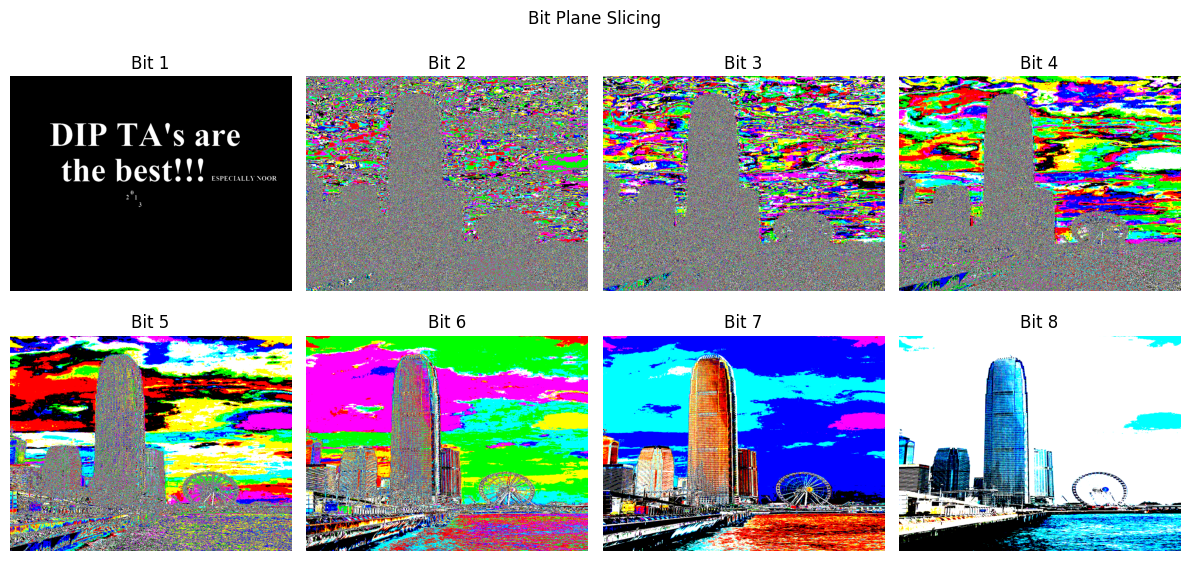

In [ ]:
cryptic_photo = read_image(f'{IMAGES_DIR}/3_mod.png')
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Bit Plane Slicing')

for i, ax in enumerate(axs.flat):
    cryptic_photo_sliced = bit_plane_slicing(cryptic_photo, i + 1)
    write_image(f'{OUTPUT_DIR}/bit_{i + 1}.png', cryptic_photo_sliced)
    display_image(cryptic_photo_sliced, f'Bit {i + 1}', ax)

plt.tight_layout()

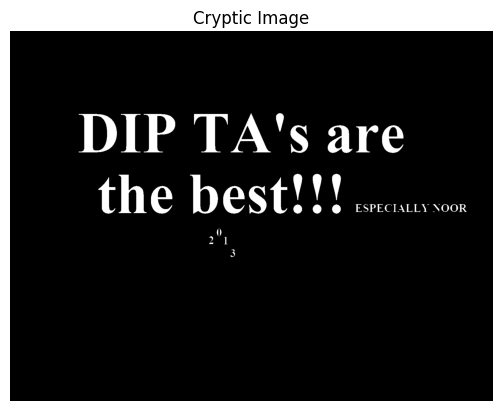

In [23]:
cryptic_image = bit_plane_slicing(cryptic_photo, 1)
display_image(cryptic_image, 'Cryptic Image')
write_image(f'{OUTPUT_DIR}/cryptic_image.png', cryptic_image)

#### 3.2 Who is the best? Especially whom?

DIP TA's, especially Noor.

#### 3.3 Why was the cryptic image weirdly proportioned?

I found the extracted image's proportion to be fine, but the base image looks weirdly proportioned. This could be attributed to resizing of the base image to match the resolution of the message image. This serves as a method to establish a one-to-one mapping between the pixels of the two images, facilitating storage in bit plane.

#### 3.4 Can you explain how the cryptic image was created?

Evidently, the values in the LSB plane of the encrypted image were a function only of the message image. This means the LSB in the base image were all reset (possibly using a bit mask), before the message was embedded onto it. They were then overwritten with a 1-bit quantized version of the message image, that could be accomodated in that idle bit.

(The difference from Question 1 is that the 1-bit information here is stored in the LSB, rather than the MSB.)

#### 3.5 Crypt Function

In [24]:
def crypt(message_image: NDArray[np.uint8], base_image: NDArray[np.uint8]):
    """ Encrypts the message image in the LSB plane of the base image. """

    mask = ~(np.uint8(1))
    resized_base_image = resize_image(base_image, message_image.shape[0], message_image.shape[1])
    quantized_message_image = np.zeros_like(message_image, dtype=np.uint8)
    quantized_message_image[message_image > 127] = 1

    output = resized_base_image & mask
    output = output | quantized_message_image
    return output

In [25]:
message = read_image(f'{IMAGES_DIR}/message.jpg')
socrates = read_image(f'{IMAGES_DIR}/socrates.jpg')

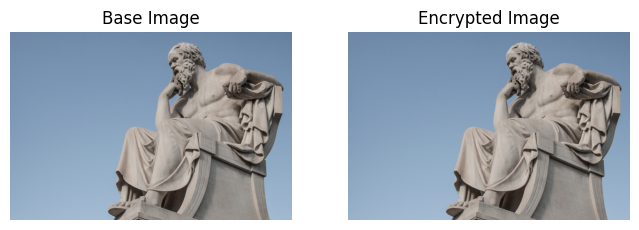

In [26]:
encrypted_image_1 = crypt(message, socrates)
write_image(f'{OUTPUT_DIR}/encrypted_image_1.png', encrypted_image_1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
display_image(socrates, 'Base Image', axs[0])
display_image(encrypted_image_1, 'Encrypted Image', axs[1])

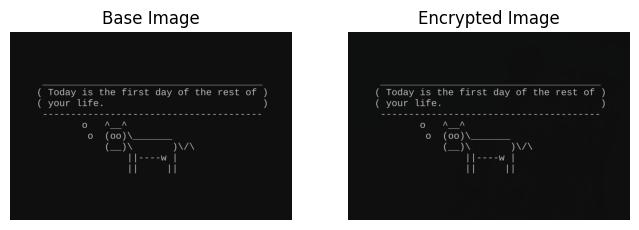

In [27]:
encrypted_image_2 = crypt(socrates, message)
write_image(f'{OUTPUT_DIR}/encrypted_image_2.png', encrypted_image_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
display_image(message, 'Base Image', axs[0])
display_image(encrypted_image_2, 'Encrypted Image', axs[1])

#### 3.6 Decrypt Function

In [28]:
def decrypt(encrypted_image: NDArray[np.uint8]):
    """ Decrypts the message in the LSB plane of the encrypted image. """

    mask = np.uint8(1)
    output = encrypted_image & mask
    output = output * 255
    return output

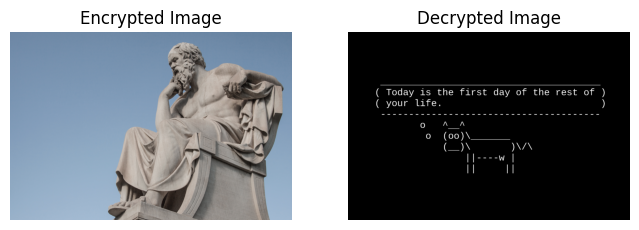

In [29]:
decrypted_image_1 = decrypt(encrypted_image_1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
display_image(encrypted_image_1, 'Encrypted Image', axs[0])
display_image(decrypted_image_1, 'Decrypted Image', axs[1])

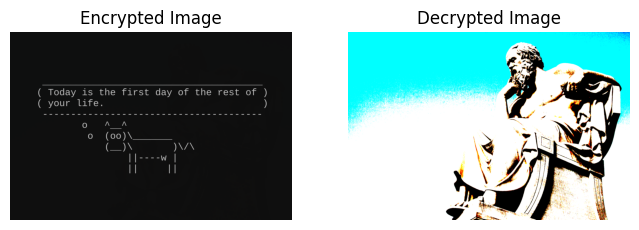

In [30]:
decrypted_image_2 = decrypt(encrypted_image_2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
display_image(encrypted_image_2, 'Encrypted Image', axs[0])
display_image(decrypted_image_2, 'Decrypted Image', axs[1])

### 4. Point-to-Point Intensity Transformation

#### 4.1 Linear Piece-wise Transformations

In [31]:
def red_transform(__data: NDArray[np.uint8], a: int = 3) -> NDArray[np.uint8]:
    """ Applies a predefined transformation to an array. """

    data = __data.astype(np.float64)

    set1 = data <= 100
    set2 = (100 < data) & (data <= 200)
    set3 = 200 < data

    output = np.zeros_like(data, dtype=np.float64)
    output[set1] = data[set1] + a
    output[set2] = (data[set2] / a) + (2 * a)
    output[set3] = 255

    output = np.rint(output)
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

def green_transform(__data: NDArray[np.uint8], a: int = 3) -> NDArray[np.uint8]:
    """ Applies a predefined transformation to an array. """

    data = __data.astype(np.float64)

    set1 = data <= 128
    set2 = 128 < data

    output = np.zeros_like(data, dtype=np.float64)
    output[set1] = (5 * data[set1]) + 1
    output[set2] = (a / data[set2]) + 8

    output = np.rint(output)
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

def blue_transform(__data: NDArray[np.uint8], a: int = 3) -> NDArray[np.uint8]:
    """ Applies a predefined transformation to an array. """

    data = __data.astype(np.float64)

    set1 = data <= 75
    set2 = (75 < data) & (data <= 200)
    set3 = 200 < data

    output = np.zeros_like(data, dtype=np.uint8)
    output[set1] = 255
    output[set2] = data[set2]
    output[set3] = 0

    return output

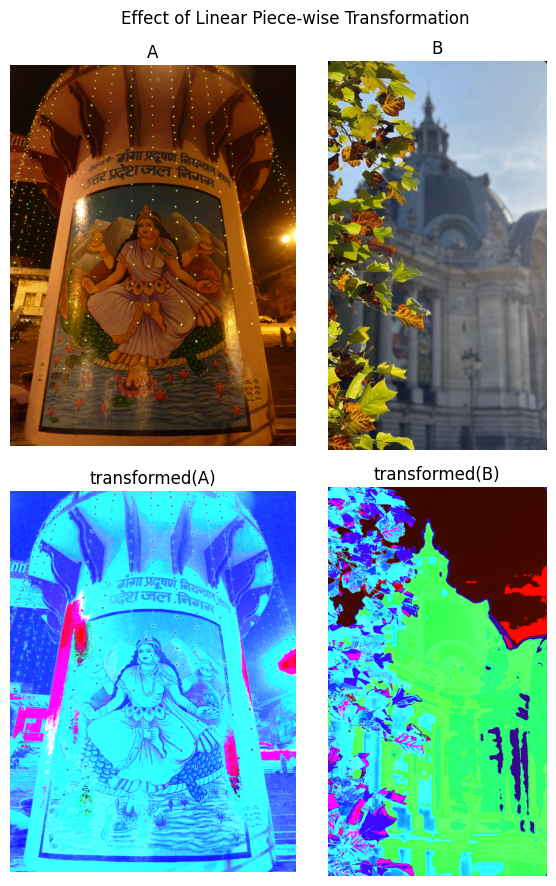

In [32]:
painting_red_transformed = red_transform(painting[:, :, 0])
painting_green_transformed = green_transform(painting[:, :, 1])
painting_blue_transformed = blue_transform(painting[:, :, 2])
painting_transformed = np.stack((painting_red_transformed, painting_green_transformed, \
                                painting_blue_transformed), axis=-1)
write_image(f'{OUTPUT_DIR}/painting_transformed.png', painting_transformed)

image_red_transformed = red_transform(image[:, :, 0])
image_green_transformed = green_transform(image[:, :, 1])
image_blue_transformed = blue_transform(image[:, :, 2])
image_transformed = np.stack((image_red_transformed, image_green_transformed, \
                                image_blue_transformed), axis=-1)
write_image(f'{OUTPUT_DIR}/image_transformed.png', image_transformed)

fig, axs = plt.subplots(2, 2, figsize=(6, 9))
fig.suptitle('Effect of Linear Piece-wise Transformation')

display_image(painting, 'A', axs[0][0])
display_image(image, 'B', axs[0][1])

display_image(painting_transformed, 'transformed(A)', axs[1][0])
display_image(image_transformed, 'transformed(B)', axs[1][1])

plt.tight_layout()

#### 4.2 Transformation Plot

In [33]:
def line_best_fit(__x: NDArray[np.uint8], __y: NDArray[np.uint8]):
    """ Finds the line of best fit, given an array of independent
    and dependent values. """

    x = __x.astype(np.float64)
    y = __y.astype(np.float64)

    x_mean = np.mean(x)
    y_mean = np.mean(y)

    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)

    slope = numerator / denominator
    intercept = y_mean - slope * x_mean
    return intercept, slope

def linear_transformation(__x: NDArray[np.uint8], coeff: Tuple[np.float64, np.float64]):
    """ Applies the linear transformation, determined by the given coefficients. """

    x = __x.astype(np.float64)

    intercept = coeff[0]
    slope = coeff[1]
    y = (x * slope) + intercept

    y = np.rint(y)
    y = np.clip(y, 0, 255).astype(np.uint8)
    return y

In [34]:
domain = np.arange(256, dtype=np.uint8)

red_transform_output = red_transform(domain)
green_transform_output = green_transform(domain)
blue_transform_output = blue_transform(domain)

red_transform_fit = line_best_fit(domain, red_transform_output)
green_transform_fit = line_best_fit(domain, green_transform_output)
blue_transform_fit = line_best_fit(domain, blue_transform_output)

red_transform_fit_output = linear_transformation(domain, red_transform_fit)
green_transform_fit_output = linear_transformation(domain, green_transform_fit)
blue_transform_fit_output = linear_transformation(domain, blue_transform_fit)

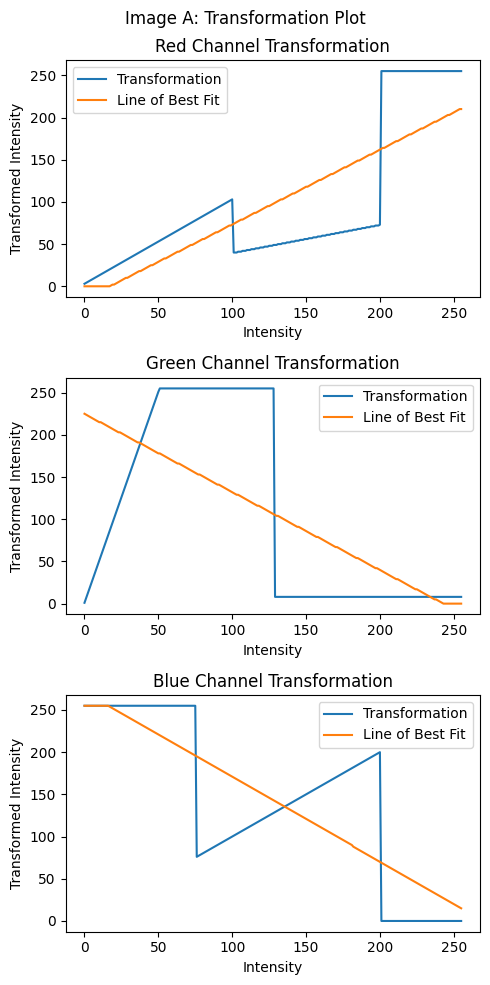

In [35]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Image A: Transformation Plot')

axs[0].plot(domain, red_transform_output, label='Transformation')
axs[0].plot(domain, red_transform_fit_output, label='Line of Best Fit')
axs[0].set_title('Red Channel Transformation')

axs[1].plot(domain, green_transform_output, label='Transformation')
axs[1].plot(domain, green_transform_fit_output, label='Line of Best Fit')
axs[1].set_title('Green Channel Transformation')

axs[2].plot(domain, blue_transform_output, label='Transformation')
axs[2].plot(domain, blue_transform_fit_output, label='Line of Best Fit')
axs[2].set_title('Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Transformed Intensity')
    ax.legend()

plt.tight_layout()

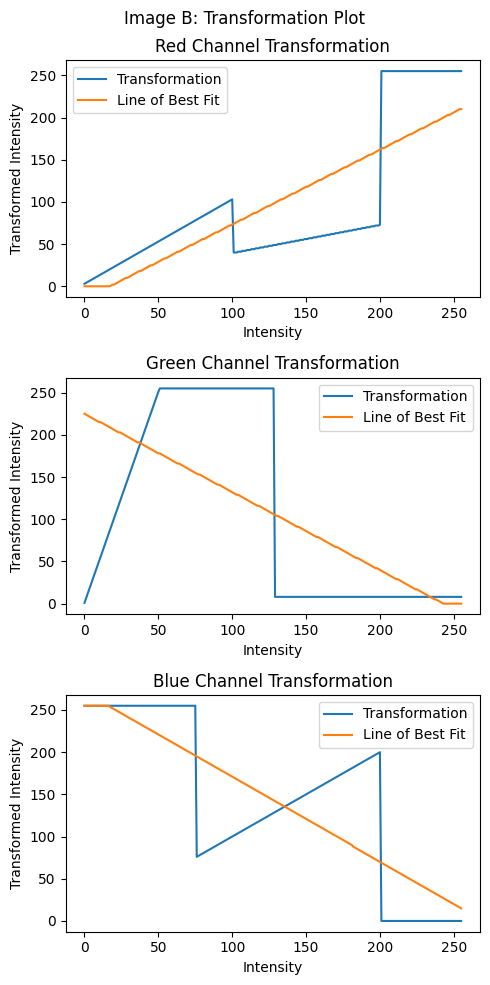

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Image B: Transformation Plot')

axs[0].plot(domain, red_transform_output, label='Transformation')
axs[0].plot(domain, red_transform_fit_output, label='Line of Best Fit')
axs[0].set_title('Red Channel Transformation')

axs[1].plot(domain, green_transform_output, label='Transformation')
axs[1].plot(domain, green_transform_fit_output, label='Line of Best Fit')
axs[1].set_title('Green Channel Transformation')

axs[2].plot(domain, blue_transform_output, label='Transformation')
axs[2].plot(domain, blue_transform_fit_output, label='Line of Best Fit')
axs[2].set_title('Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Transformed Intensity')
    ax.legend()

plt.tight_layout()

#### 4.3 Input vs Output Intensity Plot

In [37]:
painting_red_transform_fit = line_best_fit(painting[:, :, 0], painting_transformed[:, :, 0])
painting_green_transform_fit = line_best_fit(painting[:, :, 1], painting_transformed[:, :, 1])
painting_blue_transform_fit = line_best_fit(painting[:, :, 2], painting_transformed[:, :, 2])

print(painting_red_transform_fit)
print(painting_green_transform_fit)
print(painting_blue_transform_fit)

painting_red_transform_fit_output = linear_transformation(domain, painting_red_transform_fit)
painting_green_transform_fit_output = linear_transformation(domain, painting_green_transform_fit)
painting_blue_transform_fit_output = linear_transformation(domain, painting_blue_transform_fit)

(np.float64(16.907493909299895), np.float64(0.48599169789098545))
(np.float64(148.05964818443692), np.float64(0.6006531367520961))
(np.float64(261.54875678456233), np.float64(-0.5476287800294333))


/tmp/ipykernel_3190/3686441845.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/himanshu/venv/iiit/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/himanshu/venv/iiit/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


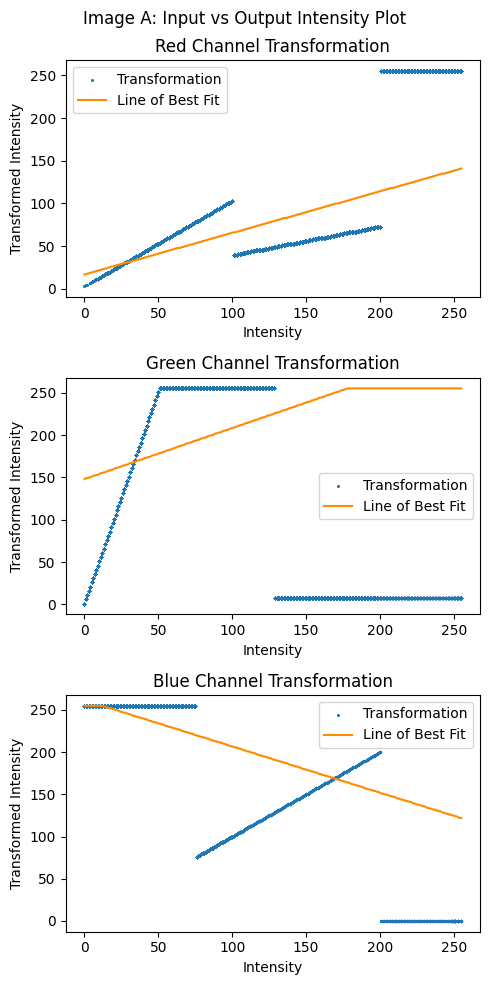

In [38]:
x_indices = np.random.choice(painting.shape[0], size=1000, replace=False)
y_indices = np.random.choice(painting.shape[1], size=500, replace=False)
painting_sub = painting[x_indices][:, y_indices]
painting_transformed_sub = painting_transformed[x_indices][:, y_indices]

fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Image A: Input vs Output Intensity Plot')

axs[0].scatter(painting_sub[:, :, 0], painting_transformed_sub[:, :, 0], label='Transformation', s=1.5)
axs[0].plot(domain, painting_red_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[0].set_title('Red Channel Transformation')

axs[1].scatter(painting_sub[:, :, 1], painting_transformed_sub[:, :, 1], label='Transformation', s=1.5)
axs[1].plot(domain, painting_green_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[1].set_title('Green Channel Transformation')

axs[2].scatter(painting_sub[:, :, 2], painting_transformed_sub[:, :, 2], label='Transformation', s=1.5)
axs[2].plot(domain, painting_blue_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[2].set_title('Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Transformed Intensity')
    ax.legend()

plt.tight_layout()

In [39]:
image_red_transform_fit = line_best_fit(image[:, :, 0], image_transformed[:, :, 0])
image_green_transform_fit = line_best_fit(image[:, :, 1], image_transformed[:, :, 1])
image_blue_transform_fit = line_best_fit(image[:, :, 2], image_transformed[:, :, 2])

print(image_red_transform_fit)
print(image_green_transform_fit)
print(image_blue_transform_fit)

image_red_transform_fit_output = linear_transformation(domain, image_red_transform_fit)
image_green_transform_fit_output = linear_transformation(domain, image_green_transform_fit)
image_blue_transform_fit_output = linear_transformation(domain, image_blue_transform_fit)

(np.float64(35.565346186263305), np.float64(0.32479725776140667))
(np.float64(361.14440854256924), np.float64(-1.663518698049515))
(np.float64(259.56631735807315), np.float64(-1.2064114134696795))


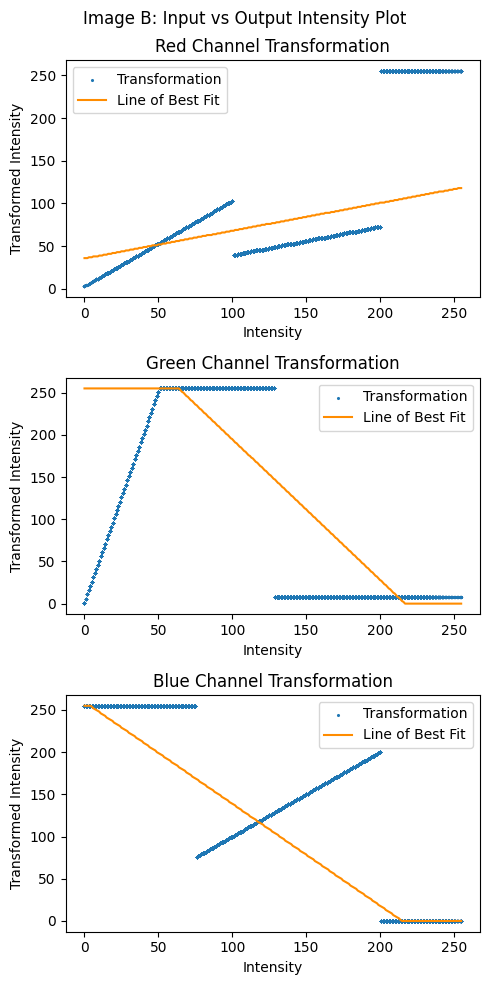

In [40]:
x_indices = np.random.choice(image.shape[0], size=1000, replace=False)
y_indices = np.random.choice(image.shape[1], size=500, replace=False)
image_sub = image[x_indices][:, y_indices]
image_transformed_sub = image_transformed[x_indices][:, y_indices]

fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Image B: Input vs Output Intensity Plot')

axs[0].scatter(image_sub[:, :, 0], image_transformed_sub[:, :, 0], label='Transformation', s=1.5)
axs[0].plot(domain, image_red_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[0].set_title('Red Channel Transformation')

axs[1].scatter(image_sub[:, :, 1], image_transformed_sub[:, :, 1], label='Transformation', s=1.5)
axs[1].plot(domain, image_green_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[1].set_title('Green Channel Transformation')

axs[2].scatter(image_sub[:, :, 2], image_transformed_sub[:, :, 2], label='Transformation', s=1.5)
axs[2].plot(domain, image_blue_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[2].set_title('Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Transformed Intensity')
    ax.legend()

plt.tight_layout()

##### Qn. Explain what you see and why?

- The transform undervalues the red intensities in the middle of the spectrum, while it undervalues green and blue in the high end of the spectrum. On the other hand, it compensate for this loss (or vice-versa), it overvalues the low intensities of green and blue channel, and the high intensities of red. It thus colors the regions with less green and less blue intensities, with green and blue respectively.

- The effect of overvaluing in green and blue channels dominate in the two images. This is demonstrated by their line of best fit (one may consider it as a ballmark estimate). This has to do the with the distribution of intensities across the channels, in the two images. While two values of frequencies may have their impacts in different directions (increase or decrease), their overall effect is determined by the weights given by their distribution (similar to weighted average).

#### 4.4 Two Choices for Line of Best Fit

/tmp/ipykernel_3190/2704185950.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


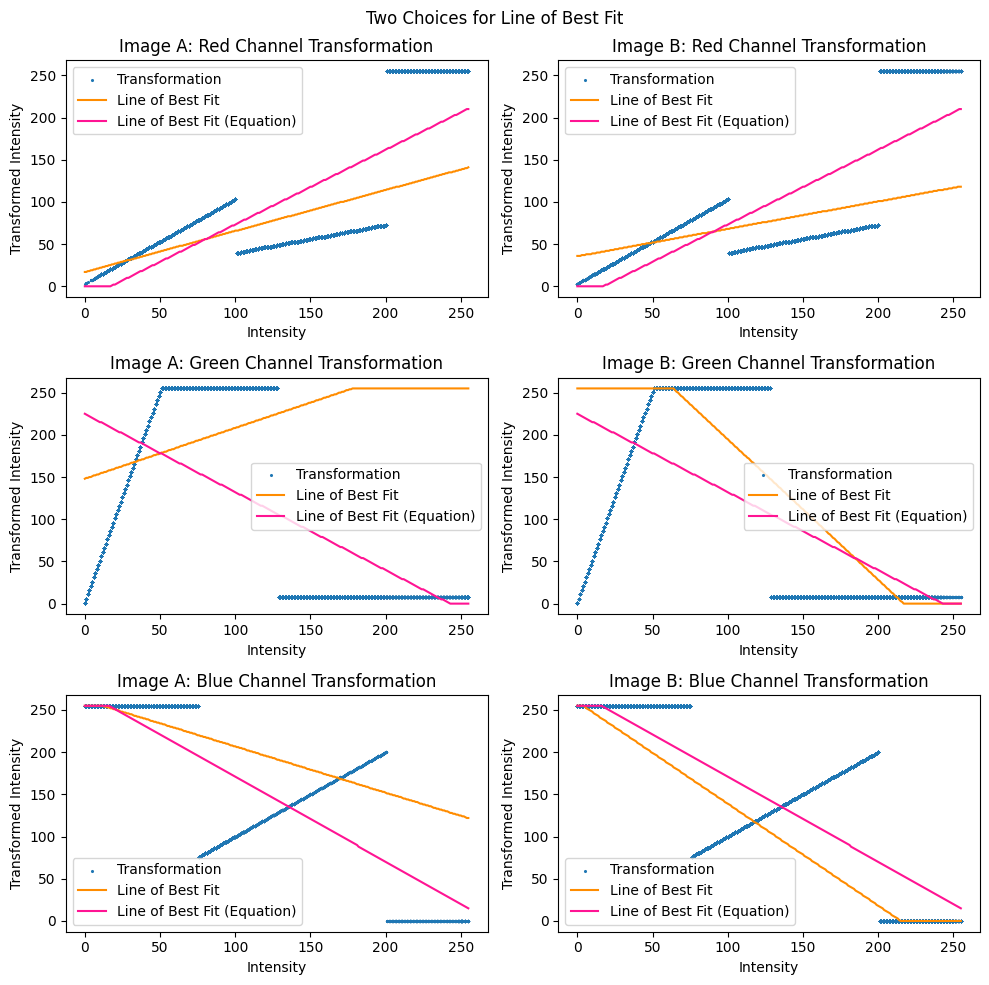

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle('Two Choices for Line of Best Fit')

axs[0][0].scatter(painting_sub[:, :, 0], painting_transformed_sub[:, :, 0], label='Transformation', s=1.5)
axs[0][0].plot(domain, painting_red_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[0][0].plot(domain, red_transform_fit_output, label='Line of Best Fit (Equation)', color='deeppink')
axs[0][0].set_title('Image A: Red Channel Transformation')

axs[1][0].scatter(painting_sub[:, :, 1], painting_transformed_sub[:, :, 1], label='Transformation', s=1.5)
axs[1][0].plot(domain, painting_green_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[1][0].plot(domain, green_transform_fit_output, label='Line of Best Fit (Equation)', color='deeppink')
axs[1][0].set_title('Image A: Green Channel Transformation')

axs[2][0].scatter(painting_sub[:, :, 2], painting_transformed_sub[:, :, 2], label='Transformation', s=1.5)
axs[2][0].plot(domain, painting_blue_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[2][0].plot(domain, blue_transform_fit_output, label='Line of Best Fit (Equation)', color='deeppink')
axs[2][0].set_title('Image A: Blue Channel Transformation')

axs[0][1].scatter(image_sub[:, :, 0], image_transformed_sub[:, :, 0], label='Transformation', s=1.5)
axs[0][1].plot(domain, image_red_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[0][1].plot(domain, red_transform_fit_output, label='Line of Best Fit (Equation)', color='deeppink')
axs[0][1].set_title('Image B: Red Channel Transformation')

axs[1][1].scatter(image_sub[:, :, 1], image_transformed_sub[:, :, 1], label='Transformation', s=1.5)
axs[1][1].plot(domain, image_green_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[1][1].plot(domain, green_transform_fit_output, label='Line of Best Fit (Equation)', color='deeppink')
axs[1][1].set_title('Image B: Green Channel Transformation')

axs[2][1].scatter(image_sub[:, :, 2], image_transformed_sub[:, :, 2], label='Transformation', s=1.5)
axs[2][1].plot(domain, image_blue_transform_fit_output, label='Line of Best Fit', color='darkorange')
axs[2][1].plot(domain, blue_transform_fit_output, label='Line of Best Fit (Equation)', color='deeppink')
axs[2][1].set_title('Image B: Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Transformed Intensity')
    ax.legend()

plt.tight_layout()

#### 4.5 Transformation using Line of Best Fit

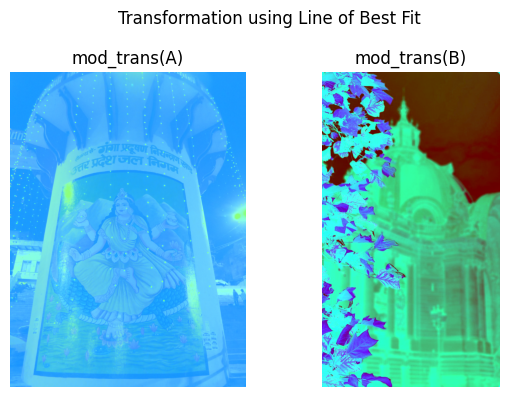

In [44]:
painting_red_fit_transformed = linear_transformation(painting[:, :, 0], painting_red_transform_fit)
painting_green_fit_transformed = linear_transformation(painting[:, :, 1], painting_green_transform_fit)
painting_blue_fit_transformed = linear_transformation(painting[:, :, 2], painting_blue_transform_fit)
painting_fit_transformed = np.stack((painting_red_fit_transformed, painting_green_fit_transformed, \
                                painting_blue_fit_transformed), axis=-1)
write_image(f'{OUTPUT_DIR}/painting_mod_transformed.png', painting_fit_transformed)

image_red_fit_transformed = linear_transformation(image[:, :, 0], image_red_transform_fit)
image_green_fit_transformed = linear_transformation(image[:, :, 1], image_green_transform_fit)
image_blue_fit_transformed = linear_transformation(image[:, :, 2], image_blue_transform_fit)
image_fit_transformed = np.stack((image_red_fit_transformed, image_green_fit_transformed, \
                                image_blue_fit_transformed), axis=-1)
write_image(f'{OUTPUT_DIR}/image_mod_transformed.png', image_fit_transformed)

fig, axs = plt.subplots(1, 2, figsize=(6, 4))
fig.suptitle('Transformation using Line of Best Fit')

display_image(painting_fit_transformed, 'mod_trans(A)', axs[0])
display_image(image_fit_transformed, 'mod_trans(B)', axs[1])

plt.tight_layout()

#### 4.6 transformed() vs mod_trans() Intensity Plot

In [45]:
painting_transformed = read_image(f'{OUTPUT_DIR}/painting_transformed.png')
painting_mod_transformed = read_image(f'{OUTPUT_DIR}/painting_mod_transformed.png')
domain = np.arange(256, dtype=np.uint8)

painting_red_fit = line_best_fit(painting_transformed[:, :, 0], painting_mod_transformed[:, :, 0])
painting_green_fit = line_best_fit(painting_transformed[:, :, 1], painting_mod_transformed[:, :, 1])
painting_blue_fit = line_best_fit(painting_transformed[:, :, 2], painting_mod_transformed[:, :, 2])

print(painting_red_fit)
print(painting_green_fit)
print(painting_blue_fit)

painting_red_fit_output = linear_transformation(domain, painting_red_fit)
painting_green_fit_output = linear_transformation(domain, painting_green_fit)
painting_blue_fit_output = linear_transformation(domain, painting_blue_fit)

(np.float64(44.434464460023754), np.float64(0.32138685329058175))
(np.float64(164.48588279771096), np.float64(0.08515380365179105))
(np.float64(168.0871998863746), np.float64(0.3232702650089752))


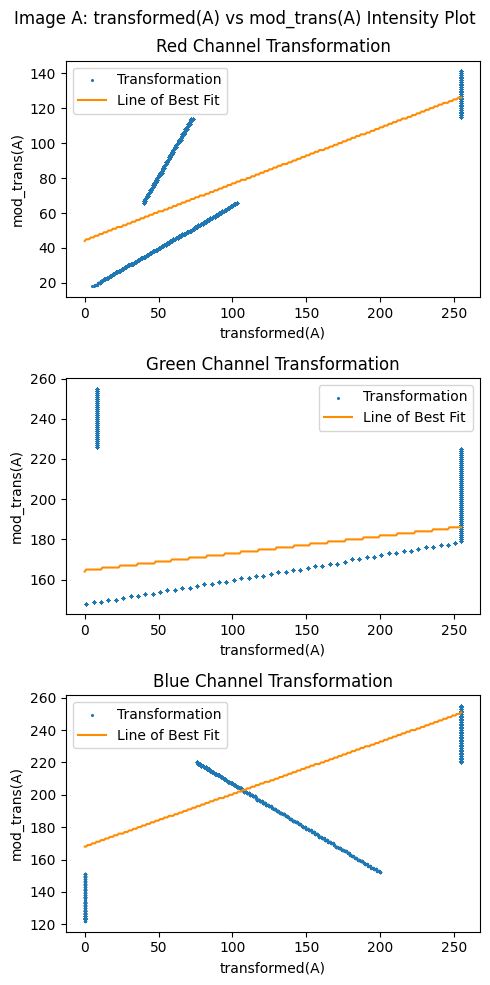

In [46]:
x_indices = np.random.choice(painting_transformed.shape[0], size=1000, replace=False)
y_indices = np.random.choice(painting_transformed.shape[1], size=500, replace=False)
painting_transformed_sub = painting_transformed[x_indices][:, y_indices]
painting_mod_transformed_sub = painting_mod_transformed[x_indices][:, y_indices]

fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Image A: transformed(A) vs mod_trans(A) Intensity Plot')

axs[0].scatter(painting_transformed_sub[:, :, 0], painting_mod_transformed_sub[:, :, 0], label='Transformation', s=1.5)
axs[0].plot(domain, painting_red_fit_output, label='Line of Best Fit', color='darkorange')
axs[0].set_title('Red Channel Transformation')

axs[1].scatter(painting_transformed_sub[:, :, 1], painting_mod_transformed_sub[:, :, 1], label='Transformation', s=1.5)
axs[1].plot(domain, painting_green_fit_output, label='Line of Best Fit', color='darkorange')
axs[1].set_title('Green Channel Transformation')

axs[2].scatter(painting_transformed_sub[:, :, 2], painting_mod_transformed_sub[:, :, 2], label='Transformation', s=1.5)
axs[2].plot(domain, painting_blue_fit_output, label='Line of Best Fit', color='darkorange')
axs[2].set_title('Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('transformed(A)')
    ax.set_ylabel('mod_trans(A)')
    ax.legend()

plt.tight_layout()

In [47]:
image_transformed = read_image(f'{OUTPUT_DIR}/image_transformed.png')
image_mod_transformed = read_image(f'{OUTPUT_DIR}/image_mod_transformed.png')
domain = np.arange(256, dtype=np.uint8)

image_red_fit = line_best_fit(image_transformed[:, :, 0], image_mod_transformed[:, :, 0])
image_green_fit = line_best_fit(image_transformed[:, :, 1], image_mod_transformed[:, :, 1])
image_blue_fit = line_best_fit(image_transformed[:, :, 2], image_mod_transformed[:, :, 2])

print(image_red_fit)
print(image_green_fit)
print(image_blue_fit)

image_red_fit_output = linear_transformation(domain, image_red_fit)
image_green_fit_output = linear_transformation(domain, image_green_fit)
image_blue_fit_output = linear_transformation(domain, image_blue_fit)

(np.float64(61.94021090763912), np.float64(0.14404737817523997))
(np.float64(58.63444497488547), np.float64(0.6240927008170337))
(np.float64(32.236448098753925), np.float64(0.7684383518585987))


/tmp/ipykernel_3190/3317038450.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


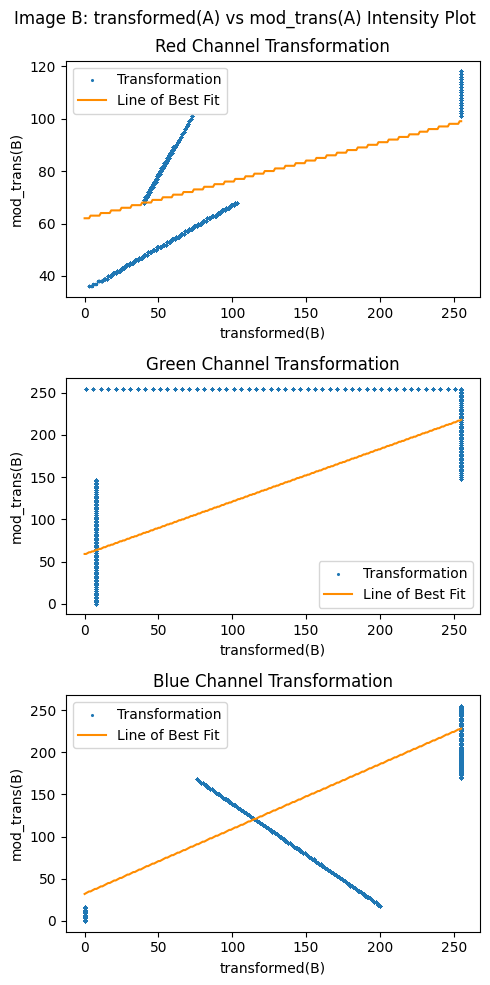

In [48]:
x_indices = np.random.choice(image_transformed.shape[0], size=1000, replace=False)
y_indices = np.random.choice(image_transformed.shape[1], size=500, replace=False)
image_transformed_sub = image_transformed[x_indices][:, y_indices]
image_mod_transformed_sub = image_mod_transformed[x_indices][:, y_indices]

fig, axs = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Image B: transformed(A) vs mod_trans(A) Intensity Plot')

axs[0].scatter(image_transformed_sub[:, :, 0], image_mod_transformed_sub[:, :, 0], label='Transformation', s=1.5)
axs[0].plot(domain, image_red_fit_output, label='Line of Best Fit', color='darkorange')
axs[0].set_title('Red Channel Transformation')

axs[1].scatter(image_transformed_sub[:, :, 1], image_mod_transformed_sub[:, :, 1], label='Transformation', s=1.5)
axs[1].plot(domain, image_green_fit_output, label='Line of Best Fit', color='darkorange')
axs[1].set_title('Green Channel Transformation')

axs[2].scatter(image_transformed_sub[:, :, 2], image_mod_transformed_sub[:, :, 2], label='Transformation', s=1.5)
axs[2].plot(domain, image_blue_fit_output, label='Line of Best Fit', color='darkorange')
axs[2].set_title('Blue Channel Transformation')

for _, ax in enumerate(axs.flat):
    ax.set_xlabel('transformed(B)')
    ax.set_ylabel('mod_trans(B)')
    ax.legend()

plt.tight_layout()

#### 4.7 Comments

- The points in the mod_trans are well distributed in the (0, 255) range, compared to trans (in case this is not evident, think of projection on the axis). Consequently, the colors in the image looks less contrastive.

- Both of them allow to extract different features from the image. For example, both image_transformed.png and image_mod_transformed.png segment the building, sky and leaves. But the latter also allows us to see through some of the internal details. As another example, consider the house behind the wall painting in painting.png and painting_transformed.png. The wall and roof of the house are well separated.

- I wouldn't consider trans() -> mod_trans() to be a filter as same intensities values in trans() axis have different correspondences in mod_trans(). For example, the range ~ (45, 70) in Red Channel. The other way round may be considered as a filter though.